### Imports  & Parameters

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# ugly workaround for imports
sys.path.append(os.path.split(os.getcwd())[0])
# sys.path.append("/Users/lab_assistant/hrf_estimation/")
from tqdm import tqdm

import numpy as np
import scipy as sp
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as pl
import matplotlib.animation as animation
%matplotlib inline

from scipy.ndimage.interpolation import rotate

from utils.fit import *
from utils.prf import *
from utils.omega import *

In [9]:
# parameters of analysis
n_pix = 35
rsq_threshold = 0.825
cv_fold=0
mask_name = 'V2'

In [3]:
# settings that have to do with the data and experiment
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-7.5, 7.5]
stim_radius = 5.0
n_folds = 6

### Get Data

`prf_cv_fold_data` is the prf parameters, 
`rfs` are the pixel-based rf profiles.

data file found, returning local file ../data/V2.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.8703387975692749, 0.0)
CSS resid:  7977.79859498
simple model (no hrf) resid:  -46352.4407399
(50, 901)


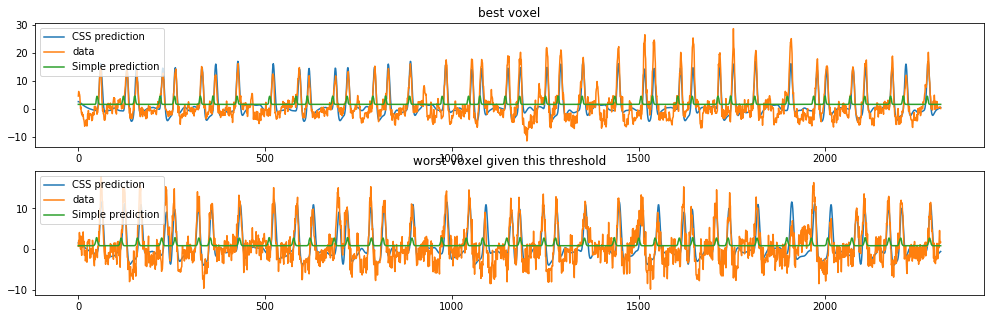

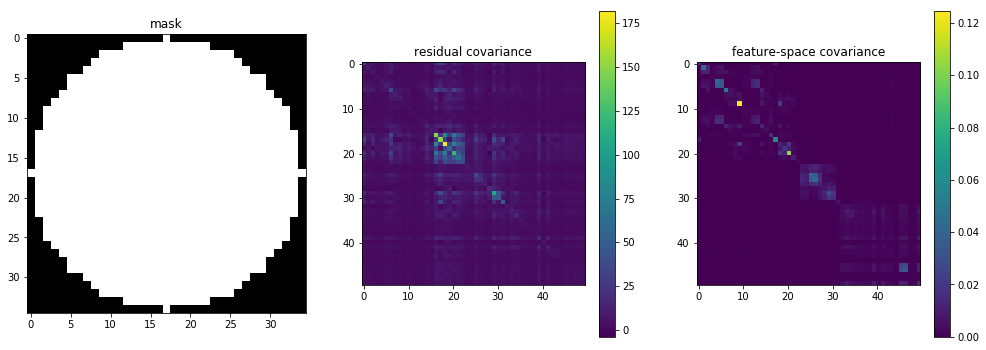

In [10]:
(prf_cv_fold_data, W, 
 all_residuals_css, all_residual_covariance_css, test_data, mask) = setup_data_from_h5(
                        data_file = '../data/%s.h5'%mask_name, 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=cv_fold,
                        n_folds=n_folds,
                        use_median=False,
                        mask_name=mask_name)

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(mask, cmap='gray');
s.set_title('mask')
s = f.add_subplot(132)
pl.imshow(all_residual_covariance_css)
s.set_title('residual covariance')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(np.dot(W,W.T))
print(W.shape)
s.set_title('feature-space covariance')
pl.colorbar();

In [29]:
#prf_cv_fold_data[:,4:6].shape
#print(linear_predictor_ip.shape)
#f = pl.figure(figsize=(6,6))
#s = f.add_subplot(131)
#pl.imshow(linear_predictor, cmap='viridis');
#s.set_title('mask')
#linear_predictor = np.dot(rfs, test_data)
#mapping_parameters=[prf_cv_fold_data[:, 3],prf_cv_fold_data[:,4:6]]
#np.shape(mapping_parameters[1])
#mask.sum()

max tau: 20.9901814996 min tau: 0.371568019738
sigma: 0.0 rho: 0.228503152321 alpha: 0.0
summed squared distance: 379516.276784


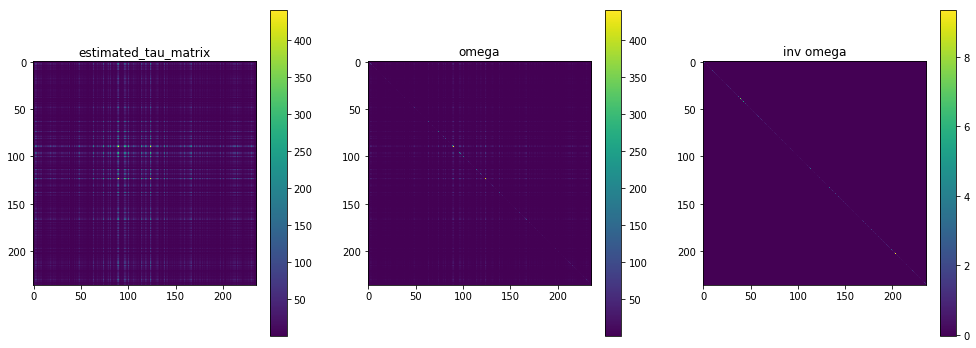

In [30]:
# estimate the covariance structure, which outputs all parameters
(estimated_tau_matrix, estimated_rho, 
 estimated_sigma, estimated_alpha, omega, 
 omega_inv, logdet) = fit_model_omega(
                                        observed_residual_covariance=all_residual_covariance_css, 
                                        WWT=np.dot(W,W.T),
                                        verbose=1,
                                        outfile='../data/omega'
                                        
)

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(estimated_tau_matrix)
s.set_title('estimated_tau_matrix')
pl.colorbar()
s = f.add_subplot(132)
pl.imshow(omega)
s.set_title('omega')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(omega_inv)
s.set_title('inv omega')
pl.colorbar();

In [31]:
# set up result array:
dm_pixel_logl_ratio = np.zeros((mask.sum(),test_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(test_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_channels(
                                        W=W,
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv,                                        
                                        mapping_relation=['power_law','linear'],
                                        mapping_parameters=[prf_cv_fold_data[:, 3],prf_cv_fold_data[:,4:6]]
                                        #mapping_relation='power_law',
                                        #mapping_parameters=prf_cv_fold_data[:, 3]
                                        )

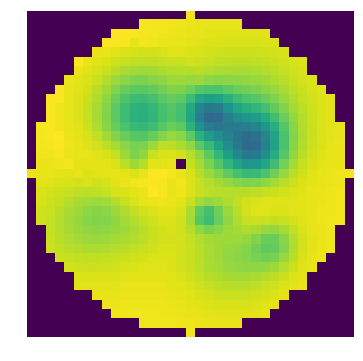

In [32]:
from IPython.display import HTML

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(dm_pixel_logl_ratio.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = dm_pixel_logl_ratio[:,t]
    im = pl.imshow(stim_2d_array, animated=True, cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)
ani
# HTML(ani.to_html5_video())
# ani.save('out.mp4', fps=30, extra_args=['-vcodec', 'libx264'], writer=animation.FFMpegFileWriter())

In [33]:
# decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
# for t, bold in enumerate(test_data.T):
#     decoded_image[:,t] = maximize_loglikelihood(
#                                         starting_value=dm_pixel_logl_ratio[:,t],
#                                         bold=bold,
#                                         logdet=logdet,
#                                         omega_inv=omega_inv,
#                                         rfs=rfs, 
#                                         prf_data=prf_cv_fold_data)
#dm_pixel_logl_ratio[:,t].shape

In [34]:
decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
for t, bold in enumerate(tqdm(test_data.T)):
    

    logl, decoded_image[:,t] = maximize_loglikelihood( starting_value=dm_pixel_logl_ratio[:,t],
                            W=W,                           
                            bold=bold,
                            logdet=logdet,
                            omega_inv=omega_inv,                            
                            mapping_relation = ['power_law', 'linear'],
                            mapping_parameters = [prf_cv_fold_data[:, 3],prf_cv_fold_data[:,4:6]]
                            #mapping_relation='power_law',
                            #mapping_parameters=prf_cv_fold_data[:, 3]
                                                     )
   

100%|██████████| 462/462 [05:46<00:00,  1.33it/s]


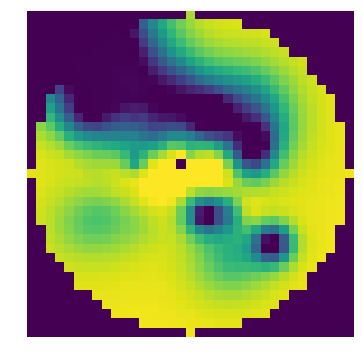

In [35]:
recon = np.zeros([decoded_image.shape[1]]+list(mask.shape) )

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(decoded_image.shape[1]):
    recon[t,mask] = decoded_image[:,t]

    im = pl.imshow(recon[t], animated=True, cmap='viridis',clim=[0,1])
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

In [36]:
thetas = [-1, 0, -1, 45, 270, -1,  315,  180, -1,  135,   90, -1,  225, -1]
rotated_recon = np.copy(recon).T

hrf_delay = 0
block_delimiters = np.r_[np.arange(2, 462, 34) + hrf_delay, 462]
reshrot_recon = np.zeros((8, rotated_recon.shape[0], rotated_recon.shape[1], 38))
bar_counter = 0
for i in range(len(block_delimiters) - 1):
    if thetas[i] != -1:
        rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4] = rotate(rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4],
                                                                                      axes=(
            0, 1),
            angle=thetas[i],
            reshape=False,
            mode='nearest')
        reshrot_recon[bar_counter] = rotated_recon[:, :,
                                                   block_delimiters[i]:block_delimiters[i + 1] + 4]
        bar_counter += 1

reshrot_recon_m = np.median(reshrot_recon, axis=0)

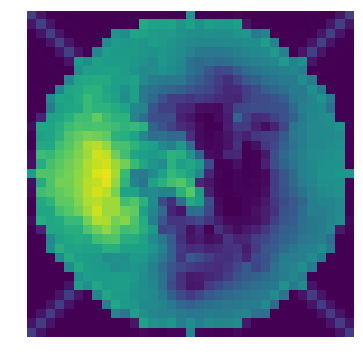

In [37]:
fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(reshrot_recon_m.shape[-1]):
    im = pl.imshow(reshrot_recon_m[...,t], animated=True, clim=[0,1], cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani.save("/Users/knapen/Desktop/mv.mp4")


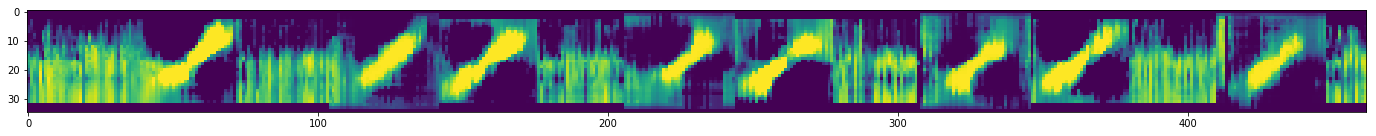

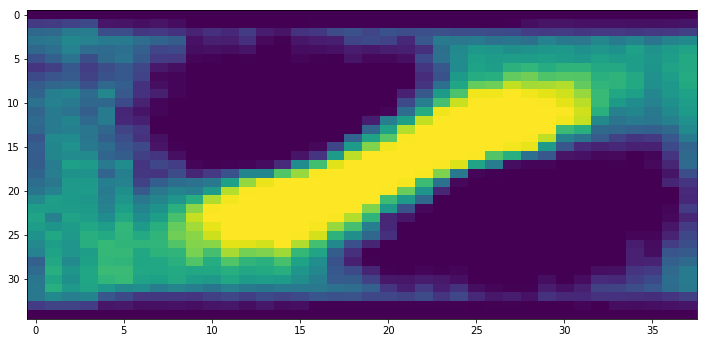

In [38]:
pl.figure(figsize=(24,7))
pl.imshow(np.median(rotated_recon, axis = 0));
pl.savefig('../data/all_tc_v2.pdf')
pl.figure(figsize=(12,6))
pl.imshow(np.median(reshrot_recon_m, axis = 0), aspect = 0.5);
pl.savefig('../data/median_tc_v2.pdf')

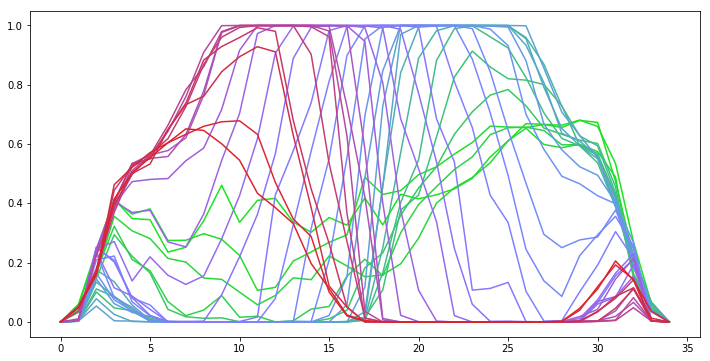

In [39]:
pl.figure(figsize=(12,6))
for t in np.arange(4,np.median(reshrot_recon_m, axis = 0).shape[1]-4):
    pl.plot(np.median(reshrot_recon_m, axis = 0)[:,t], color = (t/38, (1-t/38),0.5+-np.cos(2*np.pi*t/38)/2));

### CV across folds...

In [ ]:
# parameters of analysis
n_pix = 20
rsq_threshold = 0.7
cv_fold=0
mask_name = 'V1'
# settings that have to do with the data and experiment
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-7.5, 7.5]
stim_radius = 5.0
n_folds = 6

In [ ]:
cv_decoded_image, cv_reshrot_recon, cv_reshrot_recon_m, \
cv_omega, cv_estimated_tau_matrix, cv_estimated_rho, \
cv_estimated_sigma, cv_estimated_alpha = decode_cv_prfs(data_file='../data/%s.h5'%mask_name, 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        n_folds=n_folds,
                        use_median=False,
                        mask_name=mask_name)

  0%|          | 0/6 [00:00<?, ?it/s]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.849554717540741, 0.0)
CSS resid:  17387.5942663
simple model (no hrf) resid:  -48807.6743823



 17%|█▋        | 1/6 [01:05<05:26, 65.28s/it]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.8515167832374573, 0.0)
CSS resid:  15027.6803728
simple model (no hrf) resid:  -51168.4278823



 33%|███▎      | 2/6 [01:57<03:54, 58.63s/it]t/s]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.850906252861023, 0.0)
CSS resid:  16982.2549742
simple model (no hrf) resid:  -48126.3828757



 50%|█████     | 3/6 [02:58<02:58, 59.54s/it]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.8475784659385681, 0.0)
CSS resid:  16225.7547551
simple model (no hrf) resid:  -47567.7686588



 67%|██████▋   | 4/6 [03:57<01:58, 59.33s/it]t/s]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.8874651789665222, 0.0)
CSS resid:  13137.3530194
simple model (no hrf) resid:  -53488.4767042



 83%|████████▎ | 5/6 [04:47<00:57, 57.55s/it]t/s]

data file found, returning local file ../data/V1.h5
Shapiro-Wilk normality test (if second value is large, residuals are normal): (0.8457686305046082, 0.0)
CSS resid:  15876.5334693
simple model (no hrf) resid:  -49252.7761124



 78%|███████▊  | 360/462 [00:36<00:10,  9.80it/s]

In [ ]:
pl.figure(figsize=(12,6))
path = np.median(np.median(cv_reshrot_recon_m, axis=0), axis=0)
pl.imshow(path, aspect = 0.5);
pl.savefig('../data/cv_decoding.pdf')

In [ ]:
pl.figure(figsize=(12,6))
m_cv_rr = np.median(np.median(cv_reshrot_recon_m, axis=0), axis=0)
for t in np.arange(4,m_cv_rr.shape[1]-4):
    pl.plot(m_cv_rr[:,t]/np.sum(m_cv_rr[:,t]), color = ((1-t/38), t/38, 0.5+-np.cos(2*np.pi*t/38)/2));